# RPA Adaptation MVP's

In [2]:
# Imports
%matplotlib inline

# Import statements
import os # for directory operations
import numpy as np # for numerical/linear algebra methods
import pandas as pd # for data(frame) processing
import pdb # for debudding
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for cool plotting
import re # for regular expression
import nltk # natural language processing toolkit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from langdetect import detect, detect_langs # for language detection
from tqdm.notebook import tqdm, trange
import time
import math
from collections import Counter
import spacy
import pickle

In [3]:
# Read full pre-processed dataset
print("Reading preprocessed data...")
data = pd.read_csv("../data/blogs_kaggle/blogger_preprocessed_data_temp.csv")
print("Done reading preprocessed data.")

Reading preprocessed data...
Done reading preprocessed data.


## Breakdowns by Topic and Gender (Heatmaps). To address the possibility of biases.

In [4]:
print(f"Dataset size after preprocessing: {data.shape[0]}")

# Drop columns that are uninformative for writing style (i.e., ID and date)
data.drop(['id', 'date'], axis = 1, inplace = True)

# Add labels for age categories
def age_to_cat(age):
    '''Returns age category label for given age number.'''

    if 13 <= int(age) <= 17:
        return '13-17'
    elif 23 <= int(age) <= 27:
        return '23-27'
    elif 33 <= int(age):
        return '33-47'
    else:
        print(int(age))
        raise ValueError("Given age not in one of pre-defined age groups.")


data['age_cat'] = data['age'].apply(age_to_cat)

Dataset size after preprocessing: 629044


In [56]:
def topic_to_cat(topic):
    
    if topic == 'indUnk':
        return 'unknown'
    elif topic == 'Student':
        return 'student'
    elif topic == "Technology":
        return 'technology'
    elif topic == 'Education':
        return 'education'
    elif topic == 'Arts':
        return 'arts'
    elif topic == 'Communications-Media':
        return 'com_med'
    elif topic == 'Internet':
        return 'internet'
    elif topic == 'Non-Profit':
        return 'non_profit'
    elif topic == 'Engineering':
        return 'engineering'
    elif topic == 'Law':
        return 'law'
    elif topic == 'Publishing':
        return 'publishing'
    elif topic == 'Science':
        return 'science'
    elif topic == 'Government':
        return 'government'
    else:
        return 'other'

# Communications-Media       0.029558
# Internet                   0.023354
# Non-Profit                 0.021598
# Engineering                0.016883
# Law                        0.013575
# Publishing                 0.011659
# Science                    0.010627
# Government                 0.010087

data['topic_cat'] = data['topic'].apply(topic_to_cat)

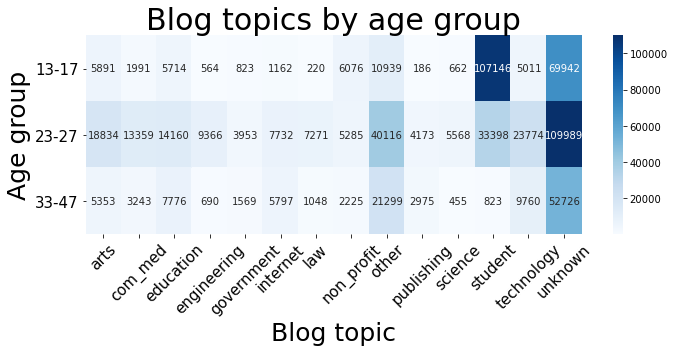

In [57]:
plt.figure(figsize=(10, 5))
sns.heatmap(pd.crosstab(data.age_cat, data.topic_cat), annot=True, fmt='g', cmap = 'Blues')
plt.xticks(rotation=45, fontsize = 15)
plt.yticks(rotation = 0, fontsize = 15)
plt.title("Blog topics by age group", fontsize = 30)
plt.xlabel("Blog topic", fontsize = 25)
plt.ylabel("Age group", fontsize = 25)
plt.tight_layout()
plt.savefig('../figures/blog_age_topic_heatmap.png')

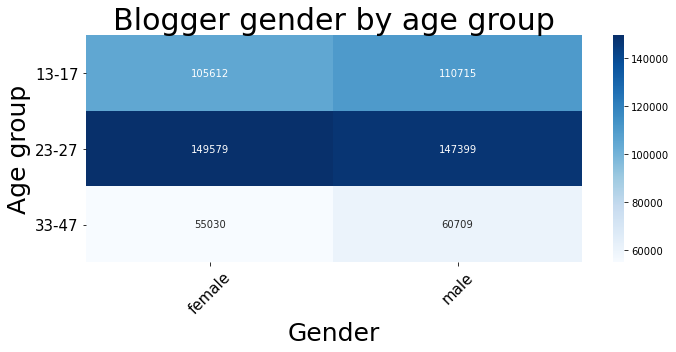

In [58]:
plt.figure(figsize=(10, 5))
sns.heatmap(pd.crosstab(data.age_cat, data.gender), annot=True, fmt='g', cmap = 'Blues')
plt.xticks(rotation=45, fontsize = 15)
plt.yticks(rotation = 0, fontsize = 15)
plt.title("Blogger gender by age group", fontsize = 30)
plt.xlabel("Gender", fontsize = 25)
plt.ylabel("Age group", fontsize = 25)
plt.tight_layout()
plt.savefig('../figures/blog_age_gender_heatmap.png')

## Baseline

In [59]:
# data.groupby(data.topic).nunique()
data.age_cat.value_counts(normalize = True)

23-27    0.472110
13-17    0.343898
33-47    0.183992
Name: age_cat, dtype: float64

In [60]:
data.topic_cat.value_counts(normalize = True)

unknown        0.369858
student        0.224733
other          0.115022
technology     0.061276
arts           0.047815
education      0.043956
com_med        0.029558
internet       0.023354
non_profit     0.021598
engineering    0.016883
law            0.013575
publishing     0.011659
science        0.010627
government     0.010087
Name: topic_cat, dtype: float64

In [61]:
data.topic.value_counts(normalize = True)

indUnk                     0.369858
Student                    0.224733
Technology                 0.061276
Arts                       0.047815
Education                  0.043956
Communications-Media       0.029558
Internet                   0.023354
Non-Profit                 0.021598
Engineering                0.016883
Law                        0.013575
Publishing                 0.011659
Science                    0.010627
Government                 0.010087
Consulting                 0.008575
Religion                   0.007871
Fashion                    0.007076
Marketing                  0.006982
Advertising                0.006891
BusinessServices           0.006516
Banking                    0.005829
Accounting                 0.005734
Chemicals                  0.005502
Telecommunications         0.005372
Museums-Libraries          0.004693
Military                   0.004661
Sports-Recreation          0.004520
HumanResources             0.004394
RealEstate                 0

In [62]:
data.gender.value_counts(normalize = True)

male      0.506837
female    0.493163
Name: gender, dtype: float64

### Following the implementation of Schler et al., predicting the majority class is a reasonable baseline. I.e., baseline is $0.47$

Text(0.5, 1.0, 'Age Group Distribution')

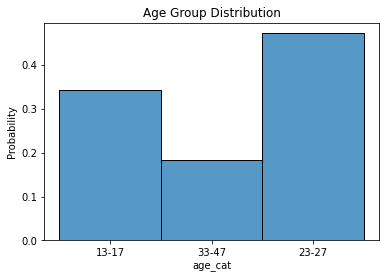

In [9]:
# Age distribution, unconditional
sns.histplot(data, x = "age_cat", binwidth = 3, stat = "probability")
plt.title("Age Group Distribution")

## Most informative features

In [10]:
# spacy english tokenizer
spacy_eng = spacy.load("en_core_web_sm")

def tokenizer_eng(text):
    text = str(text)
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

In [64]:
temp_data = data[:100000]

In [12]:
token_counter = Counter()
for sentence in temp_data.clean_data:
    for word in tokenizer_eng(sentence):
        token_counter.update([word])

In [13]:
len(token_counter)

18977

In [16]:
min_thresh = 50
trunc_counter = {x: count for x, count in token_counter.items() if count >= min_thresh}

In [17]:
len(trunc_counter)

499

In [18]:
"like" in trunc_counter

True

In [50]:
def print_top_n_thresh(vectorizer, clf, class_labels, n_feat = 100, counter = trunc_counter):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        topn = np.argsort(clf.estimators_[i].coef_)[0][-n_feat:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in topn if feature_names[j] in counter)))

In [ ]:
# Split data into features/ X and labels / Y 
X = data['clean_data']
Y = data['age_cat']

# n-gram model
vectorizer = CountVectorizer(binary = True, ngram_range = (1, 1))

# fit model
X = vectorizer.fit_transform(X.values.astype('U'))

In [53]:
# Load pretrained model
start_time = time.time()
saved_file_name = f"../logit_1_gram_seed_1"
model = pickle.load(open(saved_file_name, 'rb'))
print(f"Loading pre-trained model took {time.time() - start_time} seconds.")

Loading pre-trained model took 0.044960975646972656 seconds.


In [1]:
"like" in trunc_counter

NameError: name 'trunc_counter' is not defined

In [63]:
len(data)

629044

# Metrics

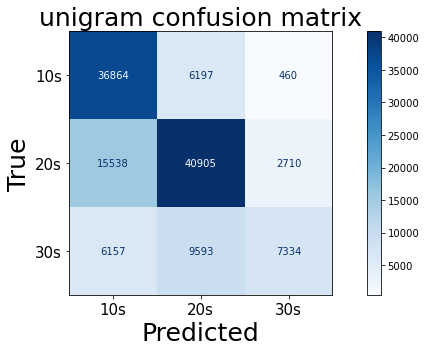

In [117]:
cm_1_gram_seed_1 = np.array([[36864, 6197, 460],[15538, 40905, 2710],[ 6157, 9593, 7334]])
tick_labels = ['10s', '20s', '30s']

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("unigram confusion matrix", fontsize = 25)
# ax.set_xticklabels()

cm_disp = ConfusionMatrixDisplay(cm_1_gram_seed_1, display_labels = tick_labels)
cm_disp.plot(ax = ax, cmap = "Blues")
# cm_disp.ax_.set(xlabel='Predicted', ylabel='True')
# cm_disp.figure_.set(figsize = (10,5))
cm_disp.figure_.set_figheight(5)
cm_disp.figure_.set_figwidth(10)
plt.ylabel("True", fontsize = 25)
plt.xlabel("Predicted", fontsize = 25)
plt.xticks(rotation=0, fontsize = 15)
plt.yticks(rotation = 0, fontsize = 15)
plt.tight_layout()
plt.savefig("../figures/blog_unigram_cm.png")

# plt.title("Hey")



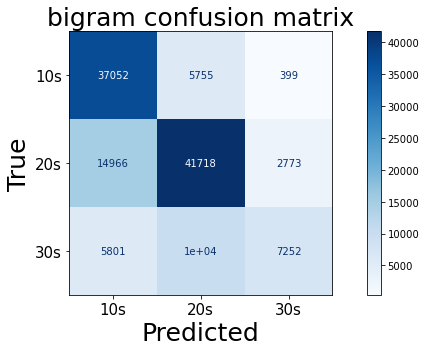

In [198]:
cm_2_gram_seed_1 = np.array([[37052,5755,399],[14966,41718,2773],[5801,10039,7252]])
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("bigram confusion matrix", fontsize = 25)
# ax.set_xticklabels()

cm_disp = ConfusionMatrixDisplay(cm_2_gram_seed_1, display_labels = tick_labels)
cm_disp.plot(ax = ax, cmap = "Blues")
# cm_disp.ax_.set(xlabel='Predicted', ylabel='True')
# cm_disp.figure_.set(figsize = (10,5))
cm_disp.figure_.set_figheight(5)
cm_disp.figure_.set_figwidth(10)
plt.ylabel("True", fontsize = 25)
plt.xlabel("Predicted", fontsize = 25)
plt.xticks(rotation=0, fontsize = 15)
plt.yticks(rotation = 0, fontsize = 15)
plt.tight_layout()
plt.savefig("../figures/blog_2_gram_seed_1_cm.png")


In [118]:
np.sum(cm_1_gram_seed_1)

125758

In [119]:
# TODO: SHUFFLE DATA
temp_data = data[:1000]

In [127]:
# spacy english tokenizer
spacy_eng = spacy.load("en_core_web_sm")

def tokenizer_eng(text):
    text = str(text)
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

token_counter = Counter()
for sentence in data.clean_data:
    for word in tokenizer_eng(sentence):
        token_counter.update([word])


In [192]:
min_thresh = 5000
trunc_counter = {x: count for x, count in token_counter.items() if count >= min_thresh}

def print_top_n_thresh(vectorizer, clf, class_labels, n_feat = 100,
                       counter = trunc_counter):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        topn = np.argsort(clf.estimators_[i].coef_)[0][-n_feat:]
        topn = topn[::-1]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in topn if feature_names[j] in counter)))

In [142]:
len(trunc_counter)

7085

In [204]:
saved_files_name = "../splits_vzer_1_gram_seed_1"
# vectorizer, _, _, _, _ = pickle.load(open(saved_files_name, 'rb')) 
_, _, _, _, Y_test = pickle.load(open(saved_files_name, 'rb')) 

In [124]:
# unigram_seed1_model = pickle.load(open("../logit_1_gram_seed_1", 'rb'))

In [195]:
class_labels_list = ['13-17', '23-27', '33-47']
print("Most informative features per age-group.")
print_top_n_thresh(vectorizer = vectorizer, clf = unigram_seed1_model, class_labels = class_labels_list, n_feat = 45000)

Most informative features per age-group.
13-17: wad homework jumper josh mrs haiz haha bye laura camp school alex lol msn math quizilla le den yay thomas mum yea tt exams omg anyways mall bored spanish summer senior soo period ur boring alright dad teachers random guitar awesome goin rob english soccer wow ppl mi bout mom debate cousin sum jus sam jon heh sarah jokes therefore youth woke bus ish everybody ryan parents teacher incredibly clock confused wo poem die mood annoying juz hey majority sooo forced whenever village shall dunno tom ate impossible matt goodbye da science hmm stupid nick practice fun waste song um title eh computer extremely ill listening adam harry leader cares tomorrow aunt typing schools likely manager grandma powerful fake alot depressed percent mad
23-27: apartment semester abt india wedding moore law drinks brian weekend teaching beer coz boss work jason
33-47: rick via daughter son gon kids husband ex master pc web vacation yard amp chick folks several jim g

In [182]:
arr = np.array([3, 2, 4,6,2,6,76,2,5,8,2,43])
sort_arr = np.argsort(arr)

print(sort_arr[-3:])
print(arr[::-1])

[ 9 11  6]
[43  2  8  5  2 76  6  2  6  4  2  3]


In [158]:
saved_files_name_2 = "../splits_vzer_1_gram_seed_2"
vectorizer_2, _, _, _, _ = pickle.load(open(saved_files_name_2, 'rb'))
unigram_seed2_model = pickle.load(open("../logit_1_gram_seed_2", 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '../splits_vzer_1_gram_seed_2'

In [ ]:
print("Most informative features per age-group.")
print_top_n_thresh(vectorizer = vectorizer, clf = unigram_seed1_model, class_labels = class_labels_list, n_feat = 20000)

In [ ]:
seeds = [1]
n_grams = [1]

In [ ]:
print("Starting training and testing loops...")
for seed in tqdm(seeds, desc = "Seed loop."):

    # set seed for reproducibility
    np.random.seed(seed)

    # shuffle dataframe
    data = data.sample(frac=1).reset_index(drop=True)


    for n in tqdm(n_grams, desc = "n gram loop."):

        # Split data into features/ X and labels / Y
        X = temp_data['clean_data']
        Y = temp_data['labels']

        # n-gram model
        vectorizer = CountVectorizer(binary = True, ngram_range = (1, n))

        # fit model
        X = vectorizer.fit_transform(X)

        # # check out a sample of the uni- and bigrams
        # print(vectorizer.get_feature_names()[:10])

        # Get label counts
        label_counts = {}

        for labels in data.labels.values:
            for label in labels:
                if label in label_counts:
                    label_counts[label] += 1
                else:
                    label_counts[label] = 1

        label_counts

        # Binarize the labels for prediction
        binarizer = MultiLabelBinarizer(classes = sorted(label_counts.keys()))

        Y = binarizer.fit_transform(data.labels)

        label_counts.keys()

        # Split data into train and test sets
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = TEST_SPLIT)

        if n == 1:
            # save splits and vectorizer
            save_file_splits_vzer = f"splits_vzer_{n}_gram_seed_{seed}"
            pickle.dump((vectorizer, X_train, X_test, Y_train, Y_test),
                        open(save_file_splits_vzer, 'wb'))


        # Fit logistic regression model
        start_time = time.time()
        model = LogisticRegression(solver = 'lbfgs', multi_class='ovr', max_iter = 1000000)
        model = OneVsRestClassifier(model)
        # model = MultiOutputClassifier(model)
        model.fit(X_train, Y_train)
        print(f"Fitting model took {time.time() - start_time} seconds.")

        # save the classifier
        save_file_name = f"logit_{n}_gram_seed_{seed}"
        pickle.dump(model, open(save_file_name, 'wb'))

        # make predictions on test set
        Y_pred = model.predict(X_test)

        Y_pred_inversed = binarizer.inverse_transform(Y_pred)
        Y_test_inversed = binarizer.inverse_transform(Y_test)

        print("=" * 81)

        print(f"n = {n}")
        print_evaluation_scores(Y_test, Y_pred)

        if n in accs_all:
            accs_all[n].append(accuracy_score(Y_test, Y_pred))
        else:
            accs_all[n] = [accuracy_score(Y_test, Y_pred)]

        # Print most informative features
        if n == 1:
            print("Most informative features per age-group.")
            print_top_n_thresh(vectorizer = vectorizer, clf = model,
                        class_labels = class_labels_list, n_feat = 20)

        print("-" * 81)
#         print("Some failure cases.")
# #         predictions = model.predict(inputs)
#         for i, (x, pred, label) in enumerate(zip(X_test, Y_pred, Y_test)):
#             if (pred != label).any():
#                 print(f"pred: {pred}")
#                 print(f"label: {label}")
#                 pred_cat = binarizer.classes_[np.where(pred == 1)[0][0]]
#                 label_cat = binarizer.classes_[np.where(label == 1)[0][0]]
#                 print(data['clean_data'][i], 'has been classified as ', pred_cat, 'and should be ', label_cat)

        print("=" * 81)

#         most_informative_feature_for_class(vectorizer = vectorizer, classifier = model, class_labels = class_labels_list, n=10)


In [203]:
# More metrix
accs_n2 = [0.6248817144447537, 0.6237843425708719, 0.6255306969422315]
print(np.mean(accs_n2))
print(np.std(accs_n2))

f1s_n2 = [0.7066727396948302, 0.7061540082165807]
print(f"Avg F1 :{np.mean(f1s_n2)}")
print(f"Std. F1 :{np.std(f1s_n2)}")

aps_n2 = [0.6124926331222166, 0.611665513481328]
print(f"Avg Precision :{np.mean(aps_n2)}")
print(f"Std. Avg. Precision :{np.std(aps_n2)}")

ars_n2 = [0.6662240069977337, 0.6663273826090413]
print(f"Avg Recall :{np.mean(ars_n2)}")
print(f"Std. Avg. Recall :{np.std(ars_n2)}")

0.6247322513192857
0.0007207370380370858
Avg F1 :0.7064133739557055
Std. F1 :0.0002593657391247728
Avg Precision :0.6120790733017722
Std. Avg. Precision :0.00041355982044427586
Avg Recall :0.6662756948033874
Std. Avg. Recall :5.16878056538439e-05


In [212]:
# Baseline performance
print(Y_test.shape)
bl_preds = np.array([[0, 1, 0], ] * Y_test.shape[0])

(125758, 3)


In [213]:
# Evaluate performance
def print_evaluation_scores(labels, preds):
    print(f"Accuracy: {accuracy_score(labels, preds)}")
    print(f"F1 score: {f1_score(labels, preds, average = 'micro')}")
    print(f"Average precision: {average_precision_score(labels, preds, average = 'micro')}")
    print(f"Average recall: {recall_score(labels, preds, average = 'micro')}")
    print(f"Confusion Matrix: {confusion_matrix(labels.argmax(axis=1), preds.argmax(axis=1))}")

In [217]:
print_evaluation_scores(Y_test, bl_preds)

Accuracy: 0.4703716662160658
F1 score: 0.4703716662160658
Average precision: 0.3977922823068561
Average recall: 0.4703716662160658
Confusion Matrix: [[    0 43521     0]
 [    0 59153     0]
 [    0 23084     0]]


# BNC

In [43]:
# Read full pre-processed dataset
print("Reading preprocessed data...")
bnc_data = pd.read_csv('../data_preprocessing/BNC/speakers_dict.csv')
print("Done reading preprocessed data.")

Reading preprocessed data...
Done reading preprocessed data.


In [44]:
bnc_data.rename(columns={"0": "speaker_id", "1": "age_range"}, inplace = True)

In [45]:
bnc_data

,speaker_id,age_range
0,S0021,19_29
1,S0032,19_29
2,S0094,30_39
3,S0095,30_39
4,S0261,40_49
...,...,...
662,S0404,11_18
663,S0373,50_59
664,S0161,70_79
665,S0629,30_39


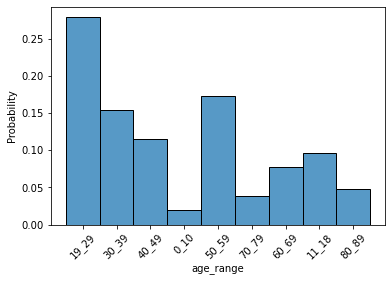

In [30]:
bins = ["0_10", "11_18", "19_29", "30_39", "40_49", "50_59", "60_69", "70_79"]
sns.histplot(bnc_data, x = "age_range", stat = "probability", hue_order = ["0_10", "11_18", "19_29", "30_39", "40_49", "50_59", "60_69", "70_79"])
plt.xticks(rotation=45)
plt.show()

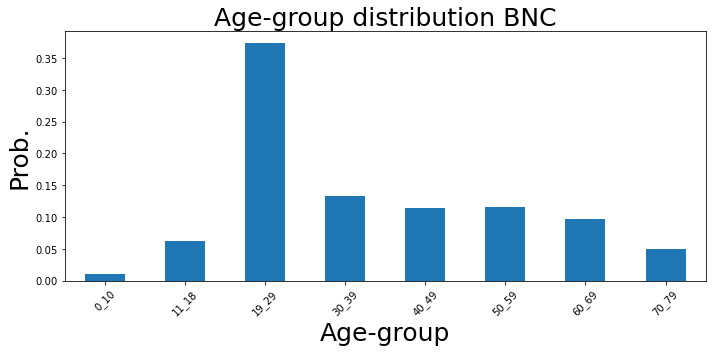

In [51]:
plt.figure(figsize=(10, 5))
bnc_data.age_range.value_counts(normalize = True).loc[bins].plot.bar(rot=45)
plt.title('Age-group distribution BNC', fontsize = 25)
plt.ylabel("Prob.", fontsize = 25)
plt.xlabel("Age-group", fontsize = 25)
plt.tight_layout()
plt.savefig("../figures/bnc_age_dist_hist.png")

In [52]:
bnc_data.age_range.value_counts(normalize = True).loc[bins]

0_10     0.010495
11_18    0.062969
19_29    0.373313
30_39    0.133433
40_49    0.113943
50_59    0.115442
60_69    0.097451
70_79    0.049475
Name: age_range, dtype: float64